# 2D Poisson problem

We rewrite [Example 17](https://github.com/kinnala/scikit-fem/blob/11.0.0/docs/examples/ex17.py) in a mesh-agnostic way after defining the mesh externally via `gmsh`.

In [1]:
import skfem
from skfem.helpers import grad, dot
from skfem.io import from_meshio
from skfem.models.poisson import mass, unit_load
from skfem.visuals.matplotlib import draw, plot
import gmsh
import meshio
import numpy as np

## Mesh

Step 1: adjust mesh

In [2]:
mm = meshio.read("disk.med")
mm.cell_sets = {
    subdomain[0]: [
        np.where(mm.cell_data["cell_tags"][ii] == idx.item())[0]
        for ii, dim in enumerate(["line", "quad"])
    ]
    for idx, subdomain in mm.cell_tags.items()
}
mesh = from_meshio(mm)
print(mesh)

<skfem MeshTri1 object>
  Number of elements: 1400
  Number of vertices: 748
  Number of nodes: 748
  Named subdomains [# elements]: core [653], ring [747]
  Named boundaries [# facets]: boundary [94]


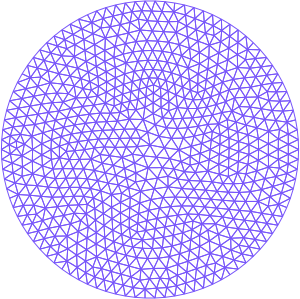

In [3]:
mesh

## Solving the problem

We start by setting the parameters: `k_values` contains the values of the thermal conductivity in the core and in the outside ring, `A` is the Joule heating, and `h` is the heat transfer.

In [4]:
k_values = {'core': 101.,  'ring': 11.}
A = 5.
h = 7.

We create bases for Quadratic elements of degree 1 and 0.

In [5]:
basis1 = skfem.Basis(mesh, skfem.ElementTriP1())
basis0 = basis1.with_element(skfem.ElementTriP0())

Next, we create a function `k` constant on all the elements.

In [6]:
k = basis0.zeros()
for s in mesh.subdomains:
    k[basis0.get_dofs(elements=s)] = k_values[s]

Then we assemble the FEM and solve the linear problem.

In [7]:
@skfem.BilinearForm
def conduction(u, v, w):
    return w.k * dot(grad(u), grad(v))
S = conduction.assemble(basis1, k=basis0.interpolate(k))

facet_basis = skfem.FacetBasis(mesh, basis1.elem, facets=mesh.boundaries['boundary'])
H = h * skfem.asm(mass, facet_basis)

core_basis = skfem.Basis(mesh, basis1.elem, elements=mesh.subdomains['core'])
b = A * skfem.asm(unit_load, core_basis)

temperature = skfem.solve(S + H, b)

<Axes: >

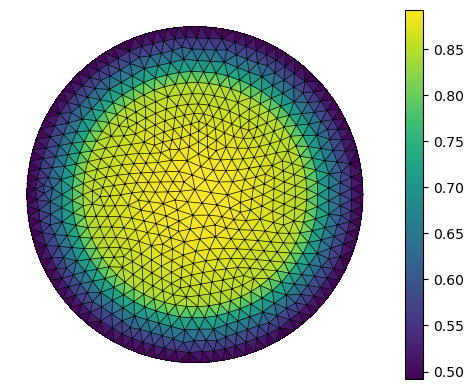

In [8]:
ax = draw(mesh)
plot(mesh, temperature, ax=ax, colorbar=True, cmap="viridis")